<a href="https://colab.research.google.com/github/der41/XAI_Duke/blob/main/Notebooks/Explainable_ML_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Techniques II
## By Diego Rodriguez

This notebook explore a PDP, ICE, and ALE plots as explainable techniques for. I bring back functions for exploratory analysis from the analysis on [interpretable models](https://github.com/der41/XAI_Duke/blob/main/Notebooks/Explainable_ML.ipynb) and plot functions from [explainable model](https://github.com/der41/XAI_Duke/blob/main/Notebooks/Machine_learning_court.ipynb) in court. Finally, all explainable techniques come from Duke [Explainable AI demo](https://github.com/AIPI-590-XAI/Duke-AI-XAI/tree/main/explainable-ml-example-notebooks) prepared by Professor Brinnae.

All the the ideas and interpretations on this Notebook are my own. AI was used on creating some auxiliary code for the preparation of this notebook.

In [1]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-r2z2do4m/alepython_4c7401b2bef045458a2d66560ad46816
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-r2z2do4m/alepython_4c7401b2bef045458a2d66560ad46816
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.1 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350ab6-py3-none-any.whl size=15251 sha256=6d252f1485b434062971118784e6b4759b7f9c13e842ef0c12f49a2f01050882
  Stored in directory: /tmp/pip-ephem-wheel-cache-u99avakd/wheels/87/54/8b/9357059e0e9ade0ea889a30fe56beaed44312e07475133b2cc
Successfully built alepython


In [2]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
import xgboost
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency


# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(42)

In [23]:
# Load Data from shap library
X,y = shap.datasets.adult()
raw_data, target = shap.datasets.adult(display=True)
# Train XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)

raw_data

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [33]:
# --- X, y and categorical_features ---
categorical_features = ["Workclass", "Marital Status", "Occupation", "Relationship", "Race", "Sex", "Country"]
numeric_features = [c for c in X.columns if c not in categorical_features]

#labels
code2label = {}
for col in categorical_features:
    # Take pairs of (code, label) from the two views
    pairs = pd.DataFrame({"code": X[col], "label": raw_data[col]}).drop_duplicates()
    # If there’s a strict one-to-one mapping, each code should map to exactly one label
    m = dict(pairs.values)
    code2label[col] = m

#print labels
print("Labels on categorical features:")
for col in categorical_features:
    print(f"{col}: {code2label[col]}")

Labels on categorical features:
Workclass: {7: ' State-gov', 6: ' Self-emp-not-inc', 4: ' Private', 1: ' Federal-gov', 2: ' Local-gov', 0: ' ?', 5: ' Self-emp-inc', 8: ' Without-pay', 3: ' Never-worked'}
Marital Status: {4: ' Never-married', 2: ' Married-civ-spouse', 0: ' Divorced', 3: ' Married-spouse-absent', 5: ' Separated', 1: ' Married-AF-spouse', 6: ' Widowed'}
Occupation: {1: ' Adm-clerical', 4: ' Exec-managerial', 6: ' Handlers-cleaners', 10: ' Prof-specialty', 8: ' Other-service', 12: ' Sales', 3: ' Craft-repair', 14: ' Transport-moving', 5: ' Farming-fishing', 7: ' Machine-op-inspct', 13: ' Tech-support', 0: ' ?', 11: ' Protective-serv', 2: ' Armed-Forces', 9: ' Priv-house-serv'}
Relationship: {0: ' Not-in-family', 4: ' Husband', 5: ' Wife', 3: ' Own-child', 1: ' Unmarried', 2: ' Other-relative'}
Race: {4: ' White', 2: ' Black', 1: ' Asian-Pac-Islander', 0: ' Amer-Indian-Eskimo', 3: ' Other'}
Sex: {1: ' Male', 0: ' Female'}
Country: {39: ' United-States', 5: ' Cuba', 23: ' Ja

## Exploratory Analysis of my variables

In [4]:


# --- Helpers ---
def cramers_v(x, y):
    """Bias-corrected Cramér's V for two categorical variables."""
    tab = pd.crosstab(x, y)
    if tab.size == 0:
        return 0.0
    chi2 = chi2_contingency(tab, correction=False)[0]
    n = tab.values.sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = tab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def correlation_ratio(categories, values):
    """η: strength of association categorical -> numeric (0..1)."""
    c = pd.Series(categories).astype("category").cat.codes
    v = pd.Series(values).astype(float)
    if v.std(ddof=0) == 0:
        return 0.0
    means = v.groupby(c).mean()
    counts = v.groupby(c).count()
    overall = v.mean()
    ss_between = (counts * (means - overall) ** 2).sum()
    ss_total = ((v - overall) ** 2).sum()
    return float(np.sqrt(ss_between / ss_total)) if ss_total > 0 else 0.0



### Pearson Correlation (Numeric Features)

In [5]:
# --- 1) Pearson correlations among numeric features ---
corr_numeric = X[numeric_features].corr(method='pearson')

### Craner V (Categorical Features)

In [6]:
# --- 2) Cramér’s V among categorical features ---
cats = categorical_features
cramers = pd.DataFrame(np.eye(len(cats)), index=cats, columns=cats, dtype=float)
for i, a in enumerate(cats):
    for j, b in enumerate(cats):
        if j < i:
            continue
        if a == b:
            v = 1.0
        else:
            v = cramers_v(X[a], X[b])
        cramers.loc[a, b] = v
        cramers.loc[b, a] = v


### Correlation ratio

In [7]:
# --- 3) Correlation ratio (η) for categorical -> numeric ---
eta = pd.DataFrame(index=categorical_features, columns=numeric_features, dtype=float)
for c in categorical_features:
    for n in numeric_features:
        eta.loc[c, n] = correlation_ratio(X[c], X[n])


# --- Pretty printing of top pairs ---
def top_pairs_from_matrix(df, k=10, absolute=False):
    vals = []
    cols = list(df.columns)
    idxs = list(df.index)
    for i in range(len(idxs)):
        for j in range(i+1, len(cols)):
            v = df.iloc[i, j]
            vals.append((idxs[i], cols[j], abs(v) if absolute else v, v))
    vals.sort(key=lambda t: t[2], reverse=True)
    out = pd.DataFrame(vals[:k], columns=["A","B","|value| (sort key)","value"])
    return out

In [8]:
top_nn = top_pairs_from_matrix(corr_numeric, k=10, absolute=True)
top_cc = top_pairs_from_matrix(cramers, k=10, absolute=False)
top_cn = (
    eta.stack()
       .rename("eta")
       .sort_values(ascending=False)
       .reset_index()
       .rename(columns={"level_0":"Categorical","level_1":"Numeric"})
       .head(10)
)

print("\nTop numeric–numeric pairs (|Pearson|):\n", top_nn.round(3))
print("\nTop categorical–categorical pairs (Cramér’s V):\n", top_cc.round(3))
print("\nTop categorical→numeric pairs (η):\n", top_cn.round(3))


Top numeric–numeric pairs (|Pearson|):
                A               B  |value| (sort key)  value
0  Education-Num  Hours per week               0.148  0.148
1  Education-Num    Capital Gain               0.123  0.123
2  Education-Num    Capital Loss               0.080  0.080
3   Capital Gain  Hours per week               0.078  0.078
4            Age    Capital Gain               0.078  0.078
5            Age  Hours per week               0.069  0.069
6            Age    Capital Loss               0.058  0.058
7   Capital Loss  Hours per week               0.054  0.054
8            Age   Education-Num               0.037  0.037
9   Capital Gain    Capital Loss               0.032 -0.032

Top categorical–categorical pairs (Cramér’s V):
                 A             B  |value| (sort key)  value
0    Relationship           Sex               0.649  0.649
1  Marital Status  Relationship               0.488  0.488
2  Marital Status           Sex               0.462  0.462
3      Occupa

The code on the cell above was produced with ChatGPT-5 to format my 3 function intro a readable list. Prompt this is the dataset: [dataset head], This is my functions for correlation, format them into a readable list.

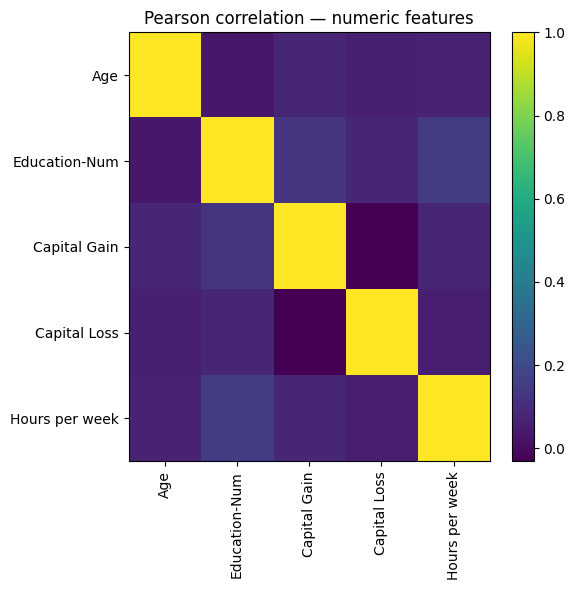

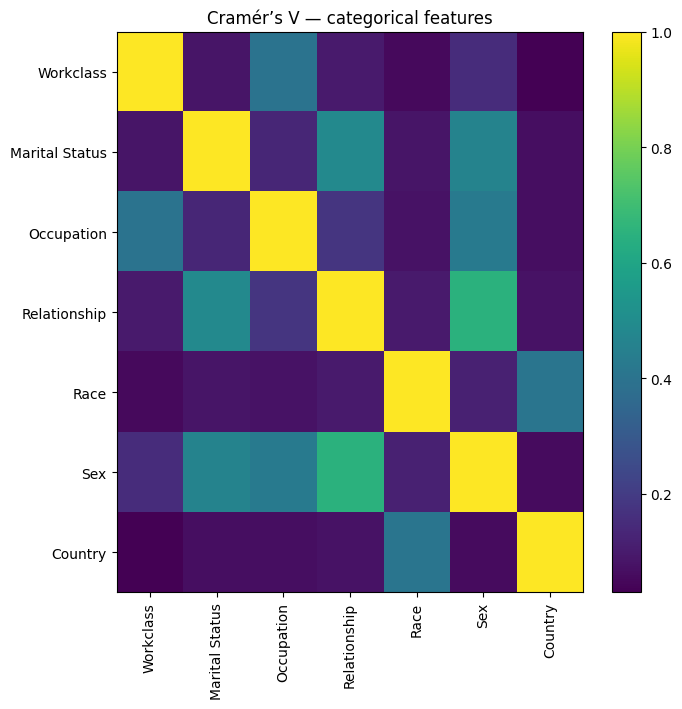

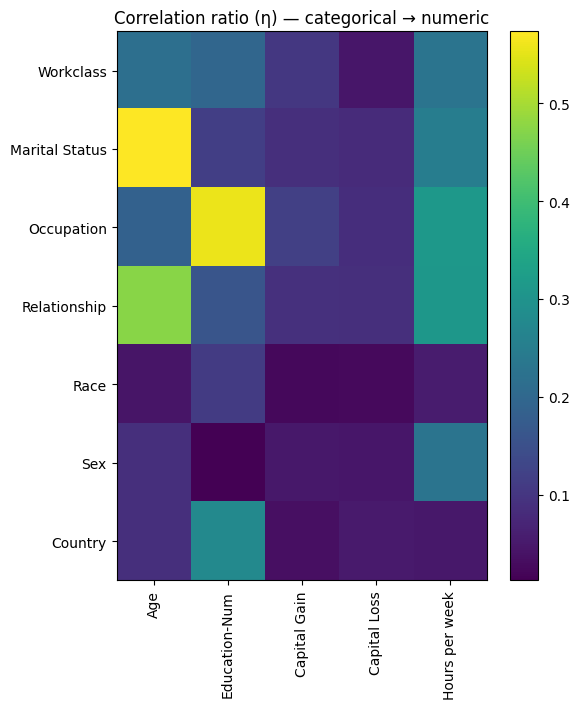

In [9]:
# --- Heatmap helper (matplotlib only, 1 chart per figure, no custom colors) ---
def heatmap(df, title):
    fig, ax = plt.subplots(figsize=(0.6*len(df.columns)+3, 0.6*len(df.index)+3))
    im = ax.imshow(df.values, aspect='auto')
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=90)
    ax.set_yticklabels(df.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# --- Render heatmaps ---
heatmap(corr_numeric, "Pearson correlation — numeric features")
heatmap(cramers, "Cramér’s V — categorical features")
heatmap(eta, "Correlation ratio (η) — categorical → numeric")

### Exploratory Analysis main takeaways

1. Strong Category to category correlation (Cramér’s V) particularly on:
  - Relationship–Sex (V≈0.65)
  - Marital Status–Relationship (V= 0.49)
  - Marital Status- Sex (V = 0.42)
  - Race - Country (V = 0.4)
  - Workclass - Occupation (V = 0.4)
2. Strong categorical to numerical signal (Correlation ratio η) particularly on:
 - Marital status - Age (η = 0.57)
 - Occupation - Education-Num (η = 0.56)
 - Relationship - Age (η = 0.47)
3. There is no strong correlation among numercal values. So, no need to explore dependecy between numerical features.

## PDP

In [10]:
def plot_pdp_manual(
    model,
    X: pd.DataFrame,
    feature,
    num: int = 80,
    grid: np.ndarray | None = None,
    target_class: int = 1,
    use_predict_proba: bool = True,
    ax=None,
    title: str | None = None,
):

    # Resolve column
    if isinstance(feature, int):
        col = X.columns[feature]
    else:
        col = feature

    # Build grid
    if grid is None:
        x_min, x_max = np.nanmin(X[col].values), np.nanmax(X[col].values)
        grid_values = np.linspace(x_min, x_max, num=num)
    else:
        grid_values = np.asarray(grid)

    # Choose prediction function
    if use_predict_proba and hasattr(model, "predict_proba"):
        def _predict(df):
            proba = model.predict_proba(df)
            # handle binary (n_classes=2) or multiclass
            return proba[:, target_class]
    else:
        def _predict(df):
            # regression or decision_function-like outputs
            return model.predict(df)

    # Compute average predictions over the grid
    avg_preds = np.zeros_like(grid_values, dtype=float)
    X_modified = X.copy()  # keep shape/columns identical for Pipelines

    for i, val in enumerate(grid_values):
        X_modified[col] = val
        preds = _predict(X_modified)
        avg_preds[i] = float(np.mean(preds))

    # Plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(grid_values, avg_preds)
    ax.set_xlabel(f"{col} values")
    ax.set_ylabel("Average predicted probability" if hasattr(model, "predict_proba") and use_predict_proba else "Average prediction")
    ax.set_title(title or f"Partial Dependence for '{col}'")
    plt.tight_layout()

    return grid_values, avg_preds, ax

The code above is based on the the code provided by Professor Brainne. To avoid biases I can use PDP for less correlated features, such as numercal features.

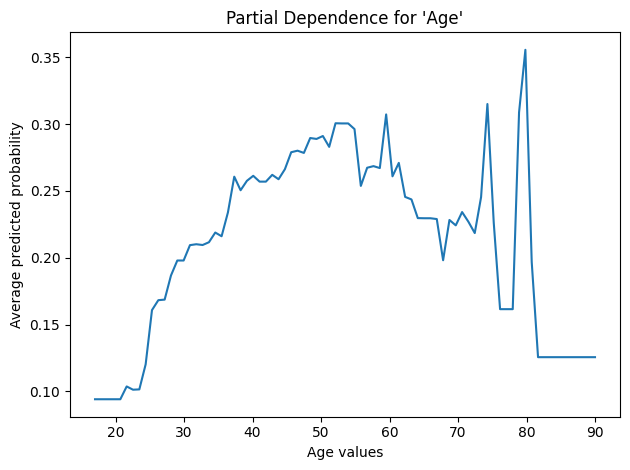

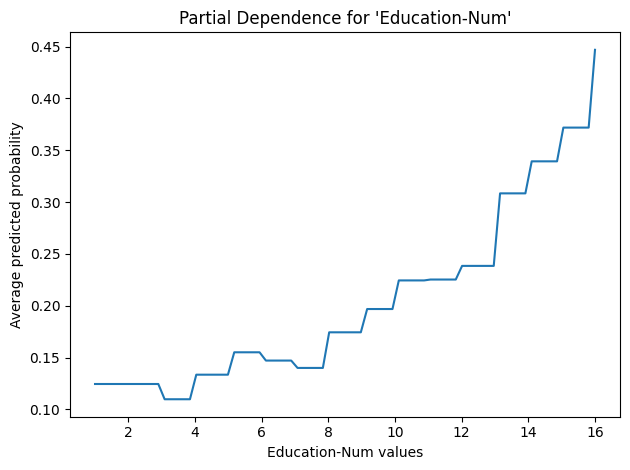

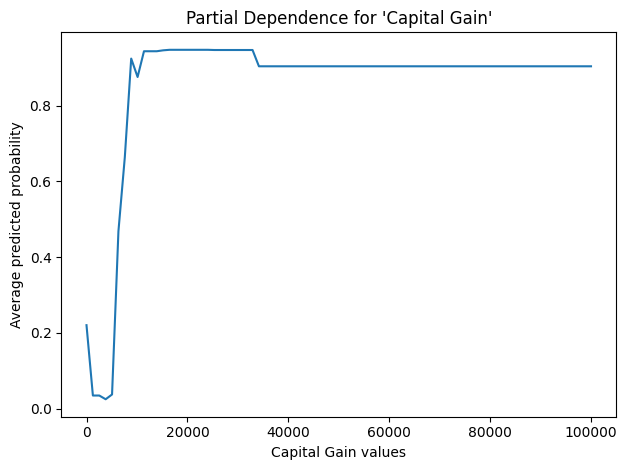

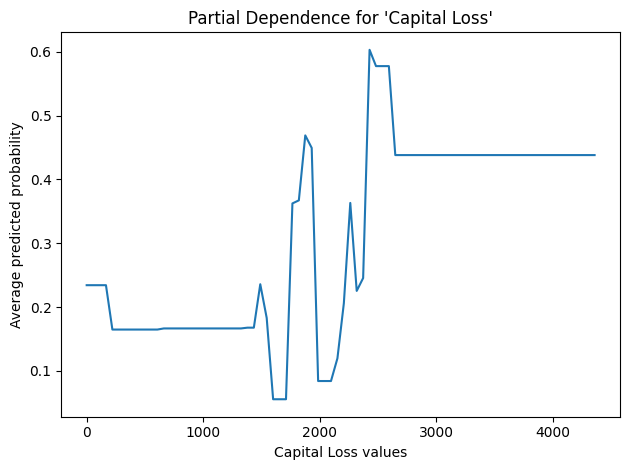

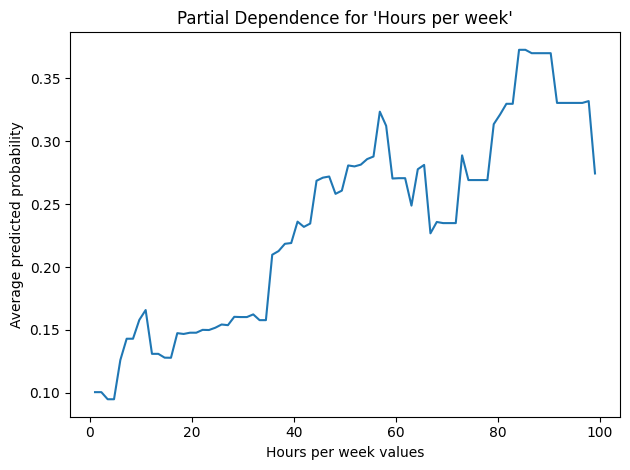

In [11]:
for col in numeric_features:
    grid, pdp, ax = plot_pdp_manual(model, X, feature=col, num=80)

### Age
Shape of the curve:
The curve is non-linear. It increases steadily from younger ages, shows some fluctuations around middle age, and then becomes noisier with sharper ups and downs at older ages.

Direction of effect:
As Age increases from around 20 to 50, the average predicted probability of earning more than 50K clearly slopes upward, meaning older individuals are more likely to be classified in the >50K category. After about 50, the curve shows mixed behavior with small declines and rebounds, indicating less stable effects in higher age ranges.

Plateaus and limits:
The curve rises strongly up to ~50 years, then plateaus and oscillates greatly, suggesting diminishing returns to age beyond that point. At very high ages (>80), the curve drops back down, likely due to fewer samples in the data (sparser regions, leading to noise).

Domain intuition:
The relationship is intuitive: in the Adult dataset, younger workers (teens/20s) generally earn less due to limited experience, while middle-aged individuals (30s–50s) have higher earning potential. The plateau and eventual drop in older ages make sense: fewer older individuals remain in high-paying full-time work, so the probability of >50K income decreases.

### Education

Shape of the curve:
The curve is monotonic and non-linear. It steadily increases as the number of years/levels of education rise, with sharper jumps at higher education levels.

Direction of effect:
As Education-Num increases, the average predicted probability of earning more than 50K slopes upward consistently. This indicates that higher education levels are strongly associated with higher income predictions.

Plateaus and limits:
There’s no plateau within the observed range. The effect keeps rising, with the steepest increases at the upper end (values 13–16), showing that advanced education (college degree and beyond) has the largest marginal impact. At the lower end (1–4), the curve is nearly flat, suggesting little difference among individuals with minimal education.

Domain intuition:
The results are intuitive and align with real-world expectations. In the Adult dataset, higher education correlates strongly with higher-paying jobs, so individuals with college or advanced degrees are much more likely to earn >50K compared to those with only elementary or some high school education.

### Capital gains

Shape of the curve:
The curve is non-linear and step-like. It starts near zero, spikes sharply upward at modest positive values, and then quickly flattens at a high predicted probability.

Direction of effect:
Increasing Capital Gain leads to a dramatic rise in the probability of earning more than 50K. After the initial jump (between ~5,000–10,000), the probability stabilizes at a very high level (>0.9).

Plateaus and limits:
The curve reaches a plateau quickly. Once an individual reports nonzero capital gains above a certain threshold, additional increases (e.g., 20,000 → 100,000) no longer have much impact—the model already strongly predicts >50K income.

Domain intuition:
This is highly intuitive: in the Adult dataset, capital gains are rare but strongly associated with wealthier individuals. Even modest positive gains are a strong indicator of high income. The plateau reflects that once the model sees any substantial capital gain, it confidently classifies the person as person that makes >50K.

### Capital Loss

Shape of the curve:
The curve is irregular and noisy. Unlike Age, Education, or Capital Gain, there is no smooth monotonic pattern. Instead, there are several spikes and drops at different ranges.

Direction of effect:
Overall, the relationship is weak compared to Capital Gain. At very low values (near 0), the predicted probability of earning >50K is modest (~0.2). Some jumps occur at intermediate losses (e.g., around 1,800–2,700), briefly pushing the probability up, but the effect is inconsistent.

Plateaus and limits:
After ~3,000, the curve seems to flatten around ~0.4, but given the noisy oscillations earlier, this is likely due to data sparsity (few individuals report large capital losses).

Domain intuition:
In the Adult dataset, Capital Loss is far less informative than Capital Gain. Few individuals report significant capital losses, so the model doesn’t learn a clear monotonic effect. The noisy spikes are likely artifacts of small sample sizes rather than meaningful signals. Compared to Capital Gain (a strong switch-like predictor), Capital Loss has a weaker and less stable relationship with high income.

### Hours per week

Shape of the curve:
The curve is non-linear with a generally upward slope, but with fluctuations. It rises steadily from low weekly hours, levels off somewhat around 40–60 hours, then shows another upward trend toward 80+ hours.

Direction of effect:
As the number of hours worked per week increases, the predicted probability of earning more than 50K increases. The slope is steepest between ~30 and 50 hours, suggesting a strong effect in that range. Beyond 60 hours, the curve continues to rise but more gradually, with some noise a variability.

Plateaus and limits:
There is a plateau effect: working more than ~ 90 hours does not further increase the probability substantially. At very low hours (< 20) the probability is close to 0.1, while typical full-time ranges (40–60) reach ~0.25–0.3, and high-hour workers (~80+) can reach ~0.35.

Domain intuition:
This is intuitive: individuals who work more hours per week are more likely to earn >50K. A standard 40-hour workweek corresponds to stable employment, while higher hours (50–60+) often signal managerial/professional roles that tend to be better paid. The plateau beyond ~90 hours reflects diminishing returns—working extremely long hours doesn’t guarantee significantly higher income.

## ICE

Let start by creating a instance based on the average or most common value. I will impose a high capital gain for the analysis. median values for numerical features and mode values for categorical features:

In [18]:
# Start with an empty dict to hold the values
focus_values = {}

# For numerics: take median (robust to skew)
for col in numeric_features:
    focus_values[col] = X[col].median()

# For categoricals: take mode (most frequent)
for col in categorical_features:
    focus_values[col] = X[col].mode()[0]

# Convert to DataFrame row
focus_instance = pd.DataFrame([focus_values])

# Replace Capital Gain with a "high" value (within observed range)
focus_instance["Capital Gain"] = 20_000  #enough to predict positive

#Converting data type to the one in X
for c in X.columns:
    focus_instance[c] = focus_instance[c].astype(X[c].dtype)

#Re indexing to the one in X
focus_instance = focus_instance.reindex(columns=X.columns)

# ✅ Now focus_instance is a 1-row DataFrame ready for your ICE plot
focus_instance

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,37.0,4,10.0,2,10,4,4,1,20000.0,0.0,40.0,39


In [13]:
#ICE Plot function identifying individual instances (Function from machine_court)
def ice_row(features, X, model, focus_instance, class_idx=1, n=100):
    """Draw a single row of ICE plots (one axis per feature)."""
    # Resolve to names
    feat_names = [X.columns[f] if isinstance(f, int) else f for f in features]

    fig, axes = plt.subplots(
        nrows=1, ncols=len(feat_names),
        figsize=(6*len(feat_names), 4),  # wider, single row
        sharey=True
    )

    if len(feat_names) == 1:
        axes = [axes]  # make iterable

    base = focus_instance.iloc[[0]].copy()

    for ax, feat_name in zip(axes, feat_names):
        # Grid over observed range
        fmin, fmax = X[feat_name].min(), X[feat_name].max()
        grid = np.linspace(fmin, fmax, n)

        # Predictions across the grid
        preds = np.empty_like(grid, dtype=float)
        for i, val in enumerate(grid):
            inst = base.copy()
            inst[feat_name] = val
            preds[i] = model.predict_proba(inst)[:, class_idx].item()

        # Patient X actual point
        x_real = float(base[feat_name].iloc[0])
        y_real = float(model.predict_proba(base)[:, class_idx][0])

        # Plot
        ax.plot(grid, preds, lw=2)
        ax.scatter([x_real], [y_real], s=60, c='red', label='Individual X')
        ax.axvline(x_real, color='red', linestyle='--', alpha=0.6)
        ax.set_xlabel(feat_name)
        ax.set_title(f'ICE – {feat_name}')
        ax.grid(alpha=0.2)

    axes[0].set_ylabel('P(class=1, Made over 50k)')
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper right')
    fig.tight_layout()
    plt.show()

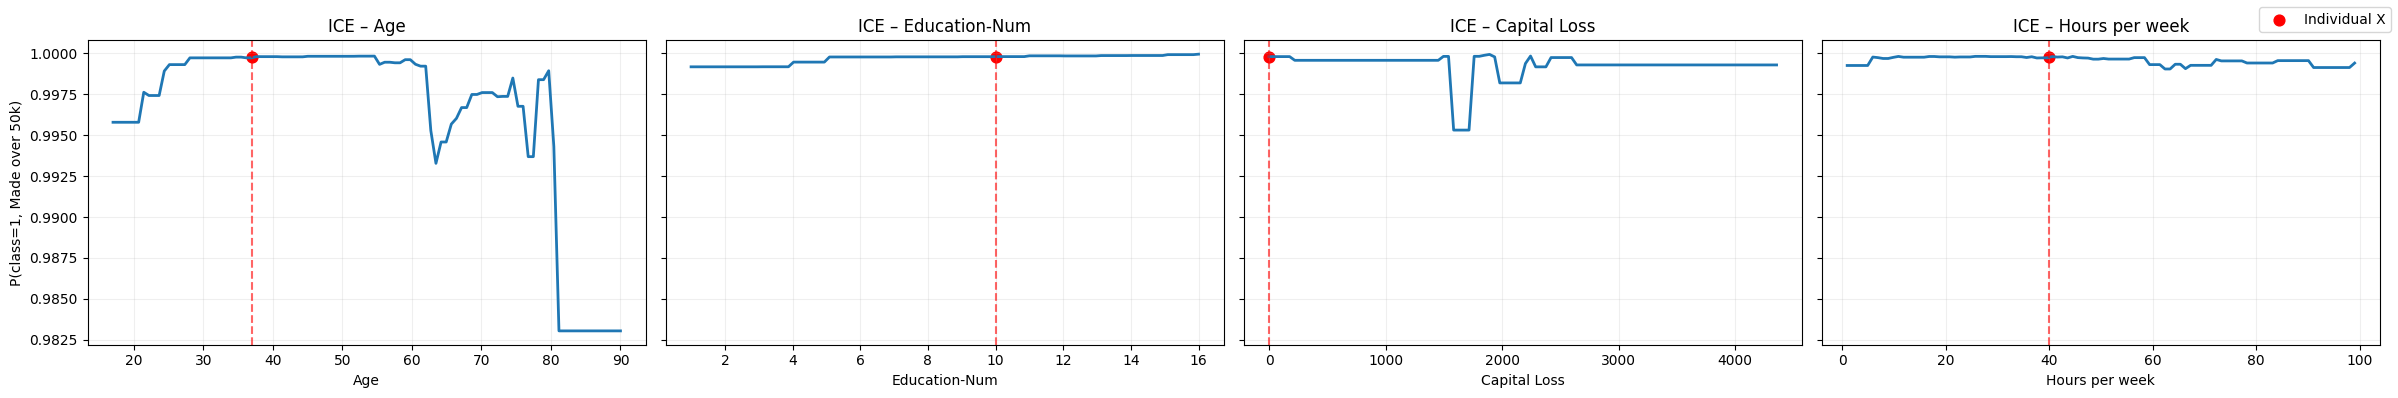

In [14]:
features_to_plot = ['Age', 'Education-Num', 'Capital Loss', 'Hours per week' ]
ice_row(features_to_plot, X, model, focus_instance, class_idx=1, n=100)

On this first case where the simulated instance had a capital gain of \$20,000 it is really hard to the model to see a reason on how this person could be making less than \$50,000 a year regardless, of Age, Education years, capital losses or Hours worked per week.

### Low capital gains

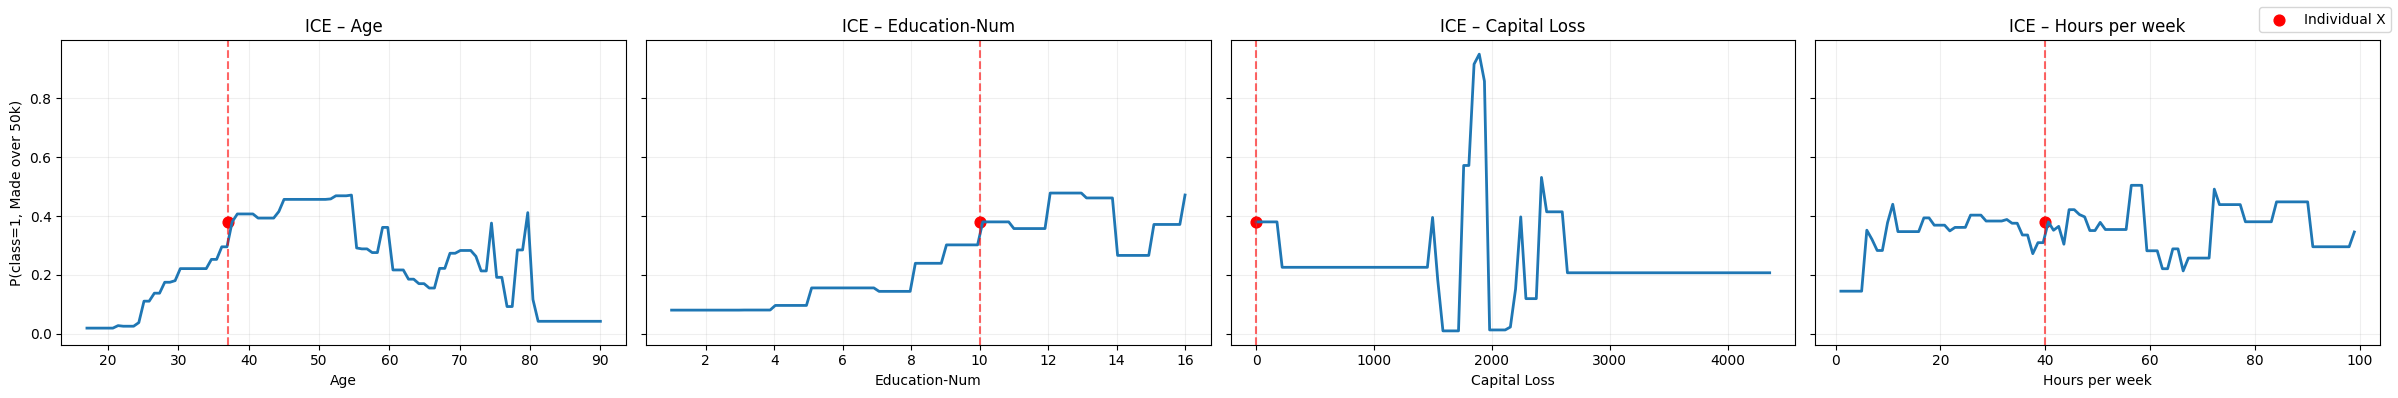

In [21]:
#replace Capital gains with a low value
focus_instance["Capital Gain"] = 5_000  #enough to predict negative

features_to_plot = ['Age', 'Education-Num', 'Capital Loss', 'Hours per week' ]
ice_row(features_to_plot, X, model, focus_instance, class_idx=1, n=100)

With a lower capital gain of \$5,000, the different variables are giving away further information regarding the predicted cases. Changes on age and education can increase the probability beyond the 50% threshold to predict that this particular person earns more than \$50,000 a year.

Lets have a first look into categorical features

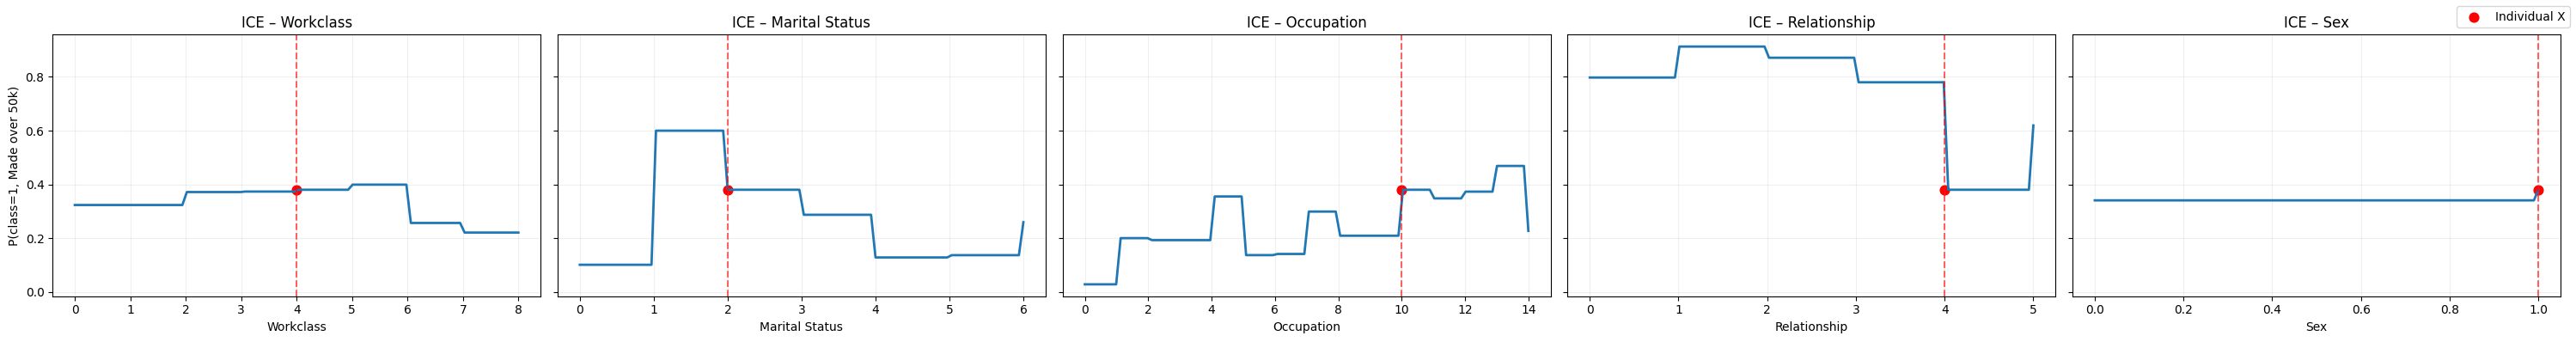

In [22]:
features_to_plot = ['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Sex']
ice_row(features_to_plot, X, model, focus_instance, class_idx=1, n=100)

On our focus instance with a capital gain of \$5,0000, we can tell that the person is a private employee (4), it has a civil spouse (2), it has a professional speiciality (10), it is the husband (4), and he is male (1).

Regarding the cateogories that could have increased the probability of being catalogue as a person with income over \$50,000 there is:
1. Self-employee would be slightly higher.
2. Married-AF is way higher predictor of income above \$50,000
3. Tech -support is a higher predictor of income above \$50,000
4. All other options would predict a higher income
5. Sex has no impact on the prediction

However, many of the categorical features were highly correlated. So, Accomulated local effects (ALE) will be more appropiate Lets now check ALE plots

## ALE

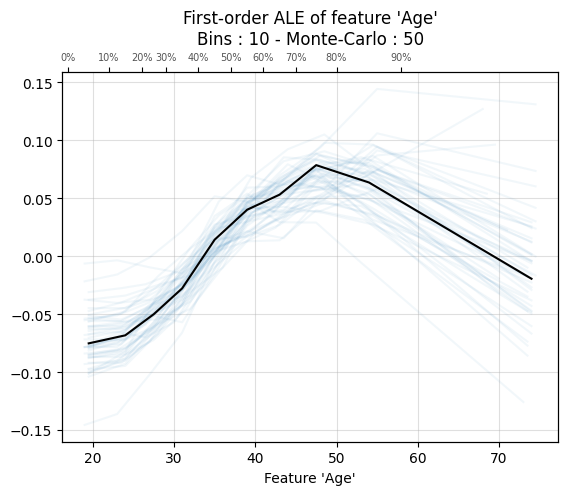

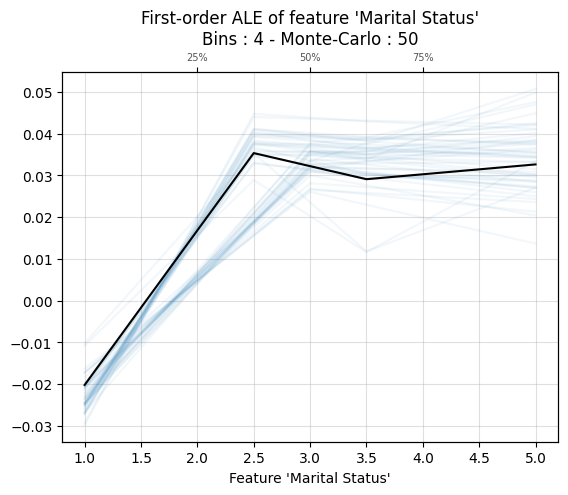

<Axes: title={'center': "First-order ALE of feature 'Marital Status'\nBins : 4 - Monte-Carlo : 50"}, xlabel="Feature 'Marital Status'">

In [31]:
ale_plot(model, X_train, 'Age', monte_carlo=True)
ale_plot(model, X_train, 'Marital Status', monte_carlo=True)

The age ALE plot is similar to the age pdp plot. It has an inverted-U relationship with high income probability: middle-aged individuals have the highest likelihood of >50K earnings, while very young or very old individuals have lower probabilities. Spikes are less common aligned to the montecarlo simulation across age predictor.Also age was showing a higher correlation with Marital status which could explain the non-linearalities observed on the age PDP.

Similarly, Marital Status shows a different shape than the ICE plot. In this particular case values like 1 shows a lower effect compared to other categories.Suggesting that as long as is not a married-AF-Spouse the odss of having a higher income than $50,000 are way higher for an individual.

Finally, let check a highly correlated category (Relationship) to see how it behaves on ALE:

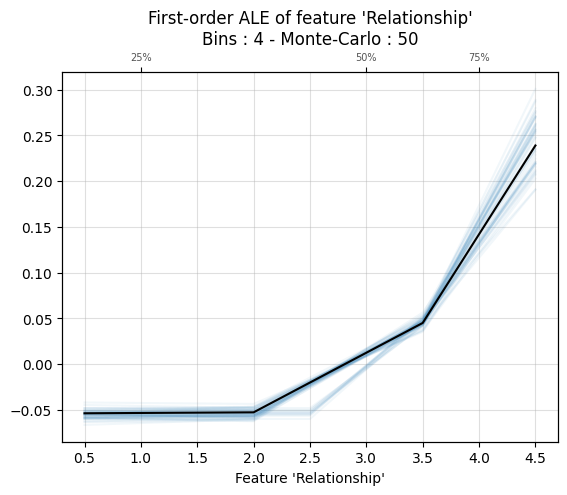

<Axes: title={'center': "First-order ALE of feature 'Relationship'\nBins : 4 - Monte-Carlo : 50"}, xlabel="Feature 'Relationship'">

In [32]:

ale_plot(model, X_train, 'Relationship', monte_carlo=True)


Relationship: {0: ' Not-in-family', 4: ' Husband', 5: ' Wife', 3: ' Own-child', 1: ' Unmarried', 2: ' Other-relative'}
Finally, Rleationship was also a strongly correlated feature. Just like the marital-status case the ALE plot shape is way different than the LIME case due to the high correlation. This ALE plot shows and increasing likelihood of predicting income above \$50,000. The order is 0 (not in family), 1 (Unmarried), 2 (Other relative), 3 (own-child),  4 (husband), 5 (wife). four and 5 are realted to leader of household. While 1 or below suggest 1-member household both related to lower income.

## Final Comments

Across PDP, ICE, and ALE, a consistent story emerges with useful nuance. Which help to validate the XgBoost model used to predict income above $50K.

PDPs showed clear global trends:
1. Education-Num is strongly monotonic (more education → higher P(>50K));
2. Hours per week rises with a threshold/plateau around full-time;
3. Age follows an inverted-U (peak mid-40s/50-ish);
4. Capital Gain behaves like a switch (any substantial positive gain → very high probability);
5. Capital Loss is noisy and comparatively weak.

These shapes are broadly intuitive help prioritize features, for example:
1. Treat Capital Gain as a high-leverage signal.
2. Education as a steadily beneficial driver.
3. Hours as exhibiting diminishing returns.

They also highlight edge-case caveats: extremes (very old/very young, very high hours) can be sparse, making PDP tails less reliable for particular segment of the population

ICE added the local lens, when focusing on particular aspects of a population, for example:
1. Being married
2. Sex
3. In professional/managerial/tech occupations with high income or service/manual roles and certain workclasses that could indicate lower income

This heterogeneity across Marital Status, Occupation, and Relationship—signals meaningful interactions that an average PDP can smooth over.

ALE then cross-checked the global patterns while being more robust to correlations, confirming the inverted-U effect for Age without over-penalizing co-movement with other variables.

As a summary for this techniques:
- Use PDP for an at-a-glance narrative, based on data (be careful with correlations).
- ICE to surface subgroup/individual differences you might act on (e.g., segment-specific policies or audits).
- ALE to validate global effects when features aren’t independent.